# Decision Trees

Experiment freely. This is a hands-on (brains off!) experience!

In [4]:
source('src/lib.R')

In [5]:
df = get_partitioned_df()
info = getModelInfo()

___

*Source: [James et al., An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Seventh%20Printing.pdf) *

___

### Tree-based methods

These involve *segmenting* the predictor space into a number of simple regions. In order **to make a prediction for a given observation**, we typically use the mean (for regression) or the mode (for regression and for classification) of the training observations in the region to which it belongs.

They are called like that because the set of splitting rule used to segment the predictor space can be summarized in a *tree*.


#### Prediction via Stratification of the Feature Space

Roughly speaking, there are two steps:

1. Divide the predictor space $X_1, X_2, \cdots X_p$ into $J$ non-overlapping regions $R_1, R_2, \cdots R_J$
2. For every observation that falls into the region $R_j$, we make the same presiftion, which is simply the mean or the mode of the responde values for those training observations in $R_j$

<img src="fig/dt_1.PNG" width="800"> 

#### Yes, but how are these *Regions* built?

In theory, they could have any shape. However, we choose to divide the predictor space into high-dimensional rectangles (or *boxes*) for simplicity.

The **goal** is to is to find the set of boxes $R_1, R_2, \cdots R_J$ that minimize the RSS (residual sum of square) given by

$\sum_{j=1}^{J}{\sum_{i \in R_j}{(y_i-\hat{y}_{R_j})}}$

where $\hat{y}_{R_j}$ is the mean response for the training observation in the *j-th* box

RSS can be used for *regression trees*, but not for *classification trees*. This is why we introduce the **classification error rate**. Since we plan classification
to assign an observation in a given region to the most commonly occurring error rate class of training observations in that region, the classification error rate is
simply the fraction of the training observations in a given region region that do not belong to the most common class.

$E = 1 - \max(\hat{p}_{mk})$

where $\hat{p}_{mk}$ represents the proportion of training observations in the m-th region that are from the k-th class. However, it turns out that classification error is not sufficiently sensitive for tree-growing, and in practice two other measures are preferable.

- **gini** $G = -\sum_{k = 1}^{k} \hat{p}_{mk} (1 - \hat{p}_{mk})$
- **entropy** (or information) $H = -\sum_{k = 1}^{k} \hat{p}_{mk} \log_{2}{\hat{p}_{mk}}$

When building a classification tree, either the Gini index or the entropy are typically used to evaluate the quality of a particular split, since these two approaches are **more sensitive** to node purity than is the classification error rate.

#### A *Greeeeeedy* algorithm

<img src="fig/greedy_scrooge.jpg" width="300"> 

Top-down, often referred as **recursive binary splitting**.

- **Greedy because** at each step of the tree building process, the *best* split is made at that particular step (rather than lookuing ahead and picking a split that would have led to a better tree in some future step.). Basically, each time we select the split on a the predictor that maximize the reduction of the RSS.
- **Recursive because** from the top of the tree (where all observations belong to a single regiion), we iteratively split the predictor space.
    - And the greedy *split selection* is performed on the partition that was created in the previous step.

___

One of the most renowned DT algorithms is called ID3: *Iterative Dichotomizer*. All others are pretty similar. 

The partitioning is performed based on an **Information Gain** $IG$ principle, a criterion based on the entropy (**information**) measure $H$.

The partitioning process is recursively recursively **until**
* the information gain from a further partitioning is too low;
* all the instances $x$ in a partition belongs to the same class $Y$;
* a pre-defined number of iteration is reached.

Notably:

* Information Gain: $IG(R_j,X_p) = H(R_j) - \sum_{s \in S} p(s)H(s)$

Where:
* $H(R_j)$ – is the entropy of set $R_j$
* $S$ – The subsets $s$ created from splitting set $R_j$ by attribute $X_p$ such that $R_j = \bigcup{s \in S}$
* $p(s)$ – The proportion of the number of elements in the sub-region $s$ to the number of elements in the region $R_j$
* $H(s)$ – Entropy of sub region $s$


In a nutshell, is the information loss from an additional partitioning significantly lower than the previous iteration?

___

In [3]:
## choose the algorithm

algorithm = 'rpart'

info[[algorithm]]$parameters

parameter,class,label
cp,numeric,Complexity Parameter


**CARET** default hyperparameter is *cp* (complexity parameter), which represents the minimal marginal decrement of the **loss function** to further partition a region. However the default split criterion here is not **intormation** but **gini**. Not a big deal, we can pass the desired criteria through a list, as specified by the [**rpart** reference manual](https://cran.r-project.org/web/packages/rpart/rpart.pdf).

In [4]:
hyperparameters = data.frame('cp' = 0.2)

# other hyperparameters

split_criterion = "information"
min_split = 20
max_depth = 30

In [5]:
# choose the dataset
data_name = 'spirals'

set.seed(123)

model = train(y = df[[data_name]]$y_train$class,
           x = df[[data_name]]$x_train,
           method = algorithm,
           tuneGrid = hyperparameters,
           parms = list(split = split_criterion), # here you can set your split criterion of choice
           control = rpart::rpart.control(minsplit = min_split, maxdepth = max_depth) # here you can choose a few fallback halting criterion other than cp
           )

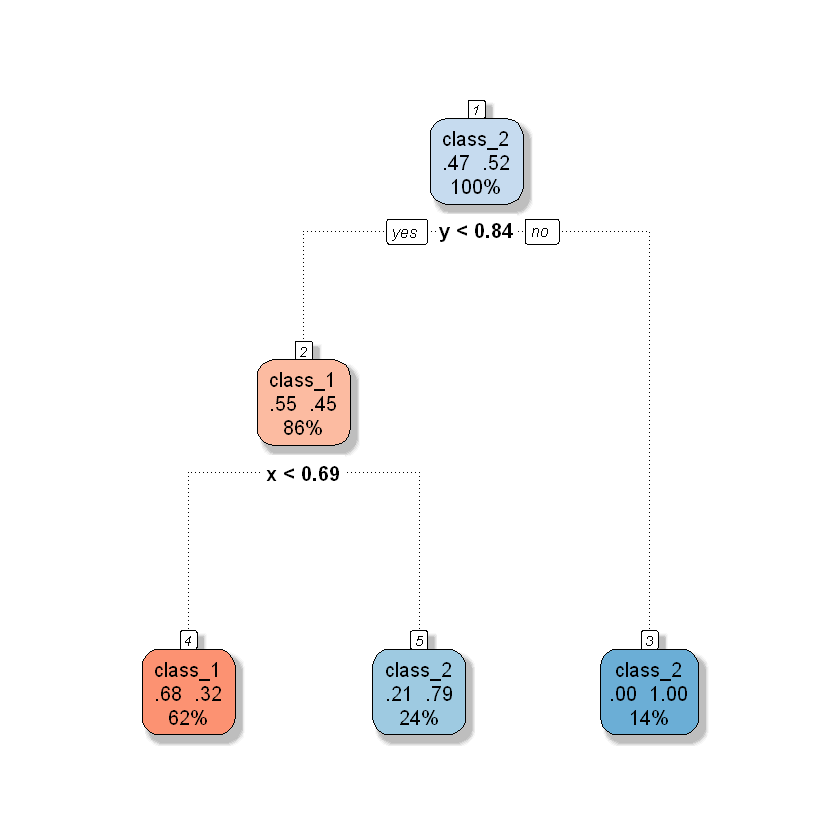

In [6]:
## plot splitting iterations
fancyRpartPlot(model$finalModel, palettes = c('Reds', 'Blues'), sub = "")

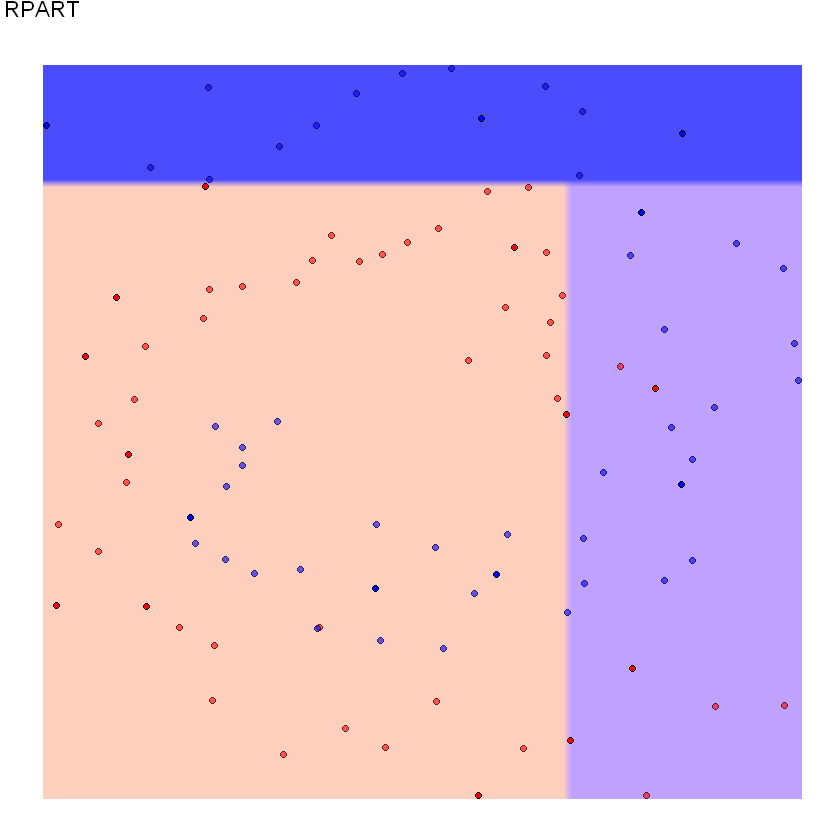

In [7]:
plot_model(df, data_name, model)

Not too good result.. this is why we require a very high **information gain** for allowing a new partition... Let's try to change something...

___

### Tweak DT Hyperparameters

In [9]:
hyperparameters = data.frame('cp' = 0.01) ## NOW WE REQUIRE A LOWER INFORMATION GAIN TO ITERATE THE PARTITIONING!

# other hyperparameters

split_criterion = "information"
min_split = 20
max_depth = 30

In [10]:
# choose the dataset

data_name = 'spirals'

set.seed(123)

model = train(y = df[[data_name]]$y_train$class,
           x = df[[data_name]]$x_train,
           method = algorithm,
           tuneGrid = hyperparameters,
           parms = list(split = split_criterion), # here you can set your split criterion of choice
           control = rpart::rpart.control(minsplit = min_split, maxdepth = max_depth) # here you can choose a few fallback halting criterion other than cp
           )

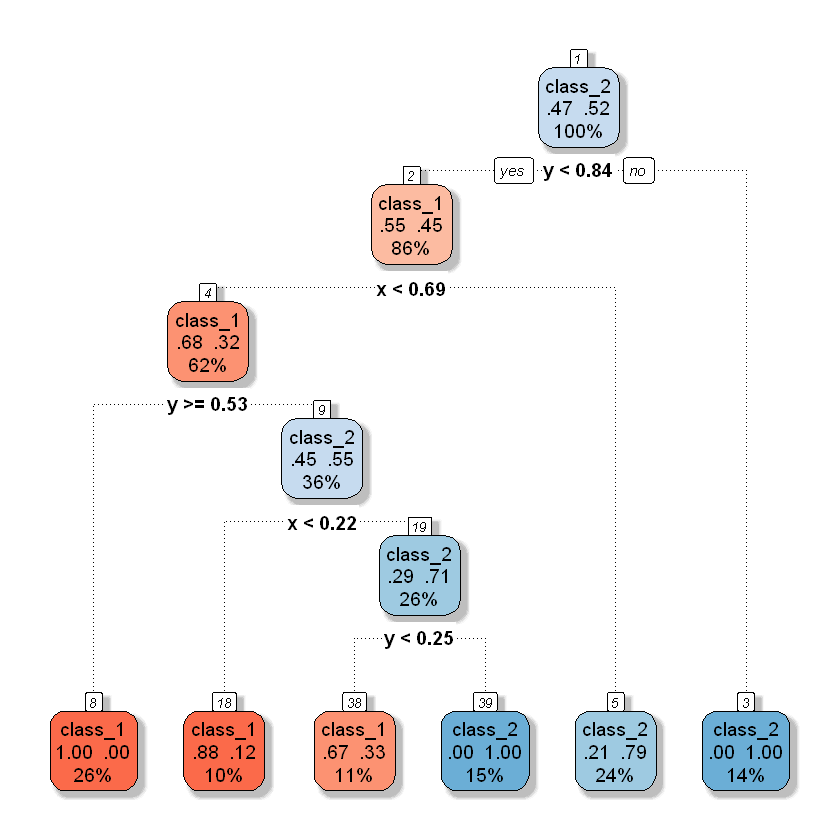

In [11]:
## plot splitting iterations
fancyRpartPlot(model$finalModel, palettes = c('Reds', 'Blues'), sub = "")

This looks neat!

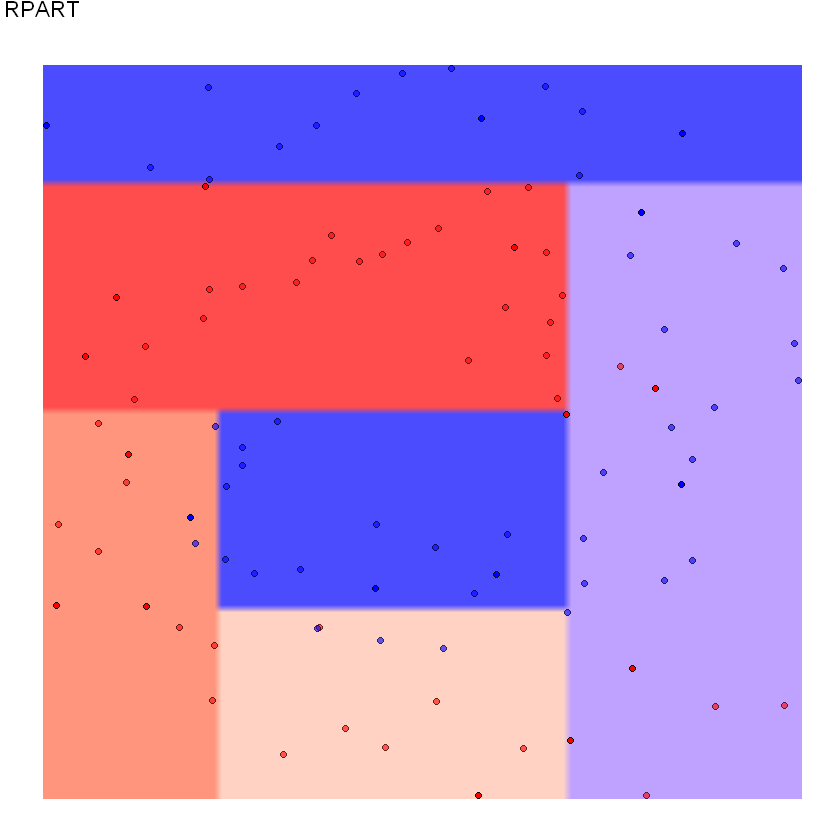

In [12]:
plot_model(df, data_name, model)

Let's go extreme!!

In [29]:
hyperparameters = data.frame('cp' = 0.0001) ## NOW WE REQUIRE An EVEN LOWER INFORMATION GAIN TO ITERATE THE PARTITIONING!

# other hyperparameters

split_criterion = "information"
min_split = 2 # AND ALSO WE ALLOW TO PARTITION VERY SMALL REGIONS
max_depth = 30

In [30]:
# choose the dataset

data_name = 'spirals'

set.seed(123)

model = train(y = df[[data_name]]$y_train$class,
           x = df[[data_name]]$x_train,
           method = algorithm,
           tuneGrid = hyperparameters,
           parms = list(split = split_criterion), # here you can set your split criterion of choice
           control = rpart::rpart.control(minsplit = min_split,
                                          maxdepth = max_depth) # here you can choose a few fallback halting criterion other than cp
           )

Technical note: if you want to use package-specific function inside a **CARET** function call (as we did for rpart.control), you must specify the **namespace**.
You can find more online about namespaces, but the $\texttt{R}$ for a namespaced function call is the follwing "NAME_OF_THE_PACKAGE::FUNCTION_FROM_THAT_PACKAGE".

Basically, you are telling the R to go search that FUNCTION_FROM_THAT_PACKAGE in that NAME_OF_THE_PACKAGE.

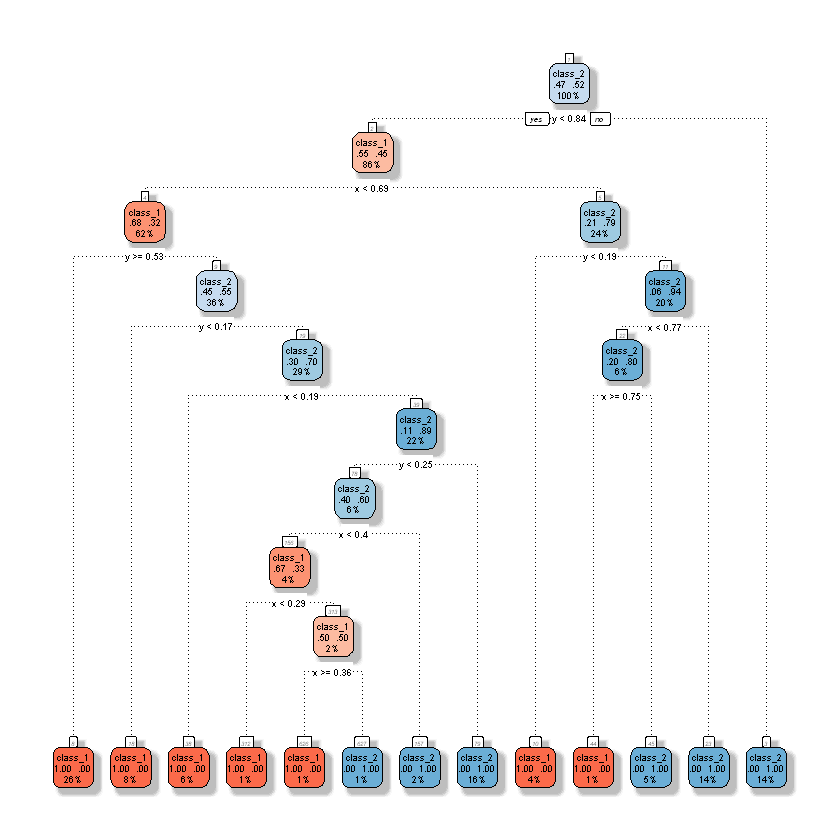

In [31]:
## plot splitting iterations
fancyRpartPlot(model$finalModel, palettes = c('Reds', 'Blues'), sub = "")

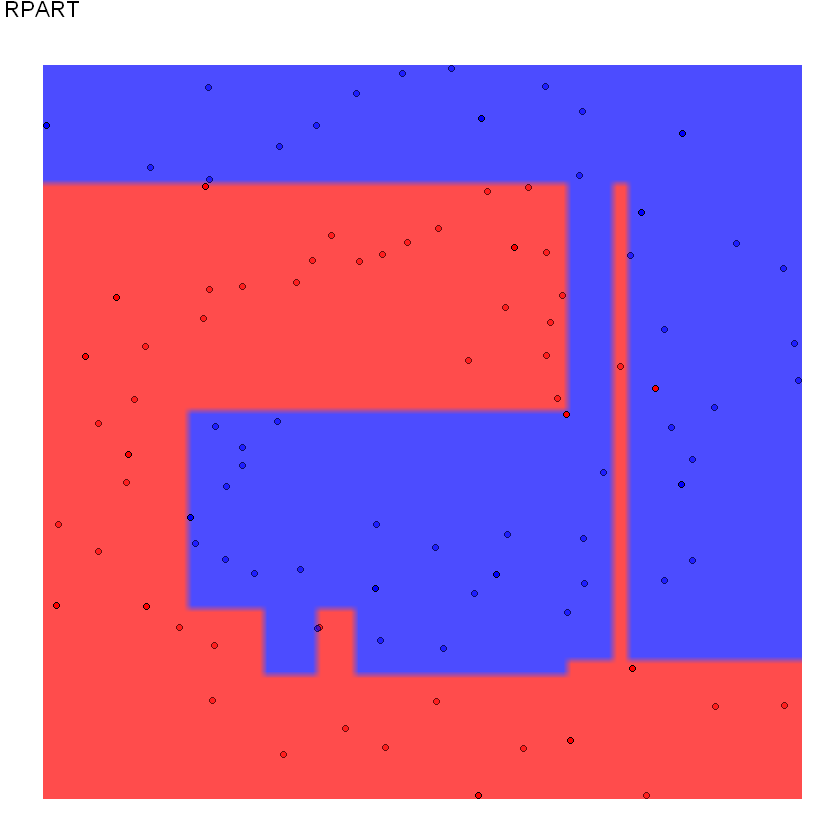

In [32]:
plot_model(df, data_name, model)

Wooops!

___
# Random Forests

*An example of **random forest** *

<img src="fig/bib_alberi.jpg" width="800"> 

They are a quite natural extension of decision trees. They aim in solving some overfitting problem of classic decision trees.

Basically a RF is the average prediction a bunch of DTs fitted on
- a bootstrapped random subsample of the dataset.
- a random subset of parameters (commonly $m = \sqrt{p}$)

In our case it is not too much of a problem, as we just have two features, but in a more complex setting this approach can really make the difference.

In [7]:
## choose the algorithm

algorithm = 'rf'
  
info[[algorithm]]$parameters
  
## set the hyperparameter

mtry = 1
  
hyperparameters = data.frame('mtry' = mtry)


parameter,class,label
mtry,numeric,#Randomly Selected Predictors


Also in this case, beyong the *CARET* default hyperparameter, we can set a few more, according to the [**randomForest** reference manual](https://cran.r-project.org/web/packages/randomForest/randomForest.pdf). There are a bunch, but we'll keep it simple for now.

In [9]:
n_tree = 25 # number of trees to grow. Set equal to the number of trees in the Biblioteca degli Alberi

## train the model

data_name = 'spirals'

model = train(y = df[[data_name]]$y_train$class,
                x = df[[data_name]]$x_train,
                method = algorithm,
                tuneGrid = hyperparameters,
                ntree = n_tree
  )

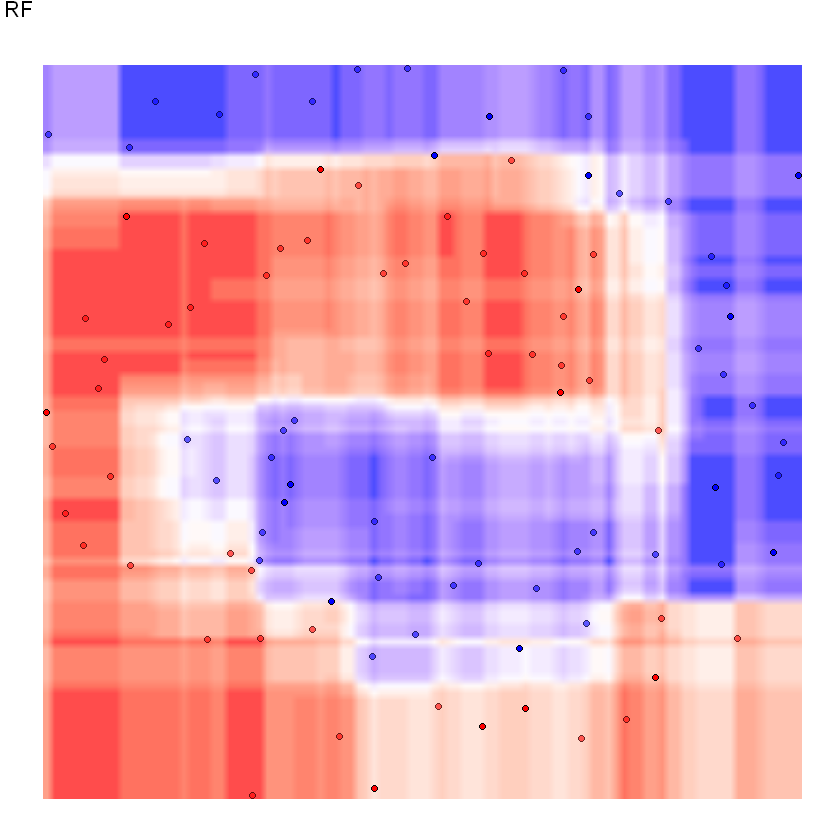

In [10]:
plot_model(df, data_name, model)